______________________________________________________________________________________________________
This notebook contains a simple variational autoencoder. 

The following resources have been helpful:
* https://arxiv.org/pdf/1606.05908v2.pdf
* https://jmetzen.github.io/2015-11-27/vae.html
_______________________________________________________________________________________________________

# Setup

In [1]:
# load MNIST data
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('data/mnist', one_hot=False)
from __future__ import print_function

np.random.seed(0)
tf.set_random_seed(0)

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


# VAE Class

In [2]:
class VAE(object):
    """ Variational Autoencoder class """
    
    def __init__(self, layers_encoder=None, layer_latent=None, layers_decoder=None, 
                 act_func=tf.nn.relu, batch_size=100, learning_rate=1e-3):
        """ Constructor for VAE class """
        
        assert layers_encoder, "Must specify layer sizes for encoder"
        assert layer_latent, "Must specify number of latent dimensions"
        assert layers_decoder, "Must specify layer sizes for decoder"
        self.layers_encoder = layers_encoder
        self.layer_latent = layer_latent
        self.layers_decoder = layers_decoder
        self.layers_decoder.insert(0, layer_latent) # helps with weight init later
        
        self.act_func = act_func
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        # define useful constants
        self.num_lvs = self.layer_latent
        self.num_layers_enc = len(self.layers_encoder)
        self.num_layers_dec = len(self.layers_decoder)
        
        # for saving and restoring models
        self.graph = tf.Graph() # must be initialized before graph creation
        
        with self.graph.as_default():
            
            # create placeholders for input and random values
            self.x = tf.placeholder(tf.float32, shape=[None, self.layers_encoder[0]])
            self.eps = tf.placeholder(tf.float32, shape=[None, self.num_lvs])
            
            # initialize weights and create model
            self._initialize_weights()
            self._define_recognition_network()
            self._define_generator_network()
            self._define_loss_optimizer()

            # add additional ops
            # for saving and restoring models
            self.saver = tf.train.Saver() # must be initialized after var creation
            # add variable initialization op to graph
            self.init = tf.initialize_all_variables()
        
    @staticmethod
    def weight_variable(shape, name='None'):
        """ Utility method to clean up initialization """
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, name=name)

    @staticmethod
    def bias_variable(shape, name='None'):
        """ Utility method to clean up initialization """
        initial = tf.constant(0.0, shape=shape)
        return tf.Variable(initial, name=name)
    
    def _initialize_weights(self):
        """ Initialize weights and biases in model """

        # initialize weights and biases in encoding model
        self.weights_enc = []
        self.biases_enc = []
        for i in range(self.num_layers_enc-1):
            self.weights_enc.append(self.weight_variable([self.layers_encoder[i], 
                                                          self.layers_encoder[i+1]],
                                                         name=str('weights_enc_%02i' % i)))
            self.biases_enc.append(self.bias_variable([self.layers_encoder[i+1]], 
                                                      name=str('biases_enc_%02i' % i)))

        # initialize weights and biases in decoding model
        self.weights_dec = []
        self.biases_dec = []
        for i in range(self.num_layers_dec-1):
            self.weights_dec.append(self.weight_variable([self.layers_decoder[i], 
                                                          self.layers_decoder[i+1]],
                                                         name=str('weights_dec_%02i' % i)))
            self.biases_dec.append(self.bias_variable([self.layers_decoder[i+1]], 
                                                      name=str('biases_dec_%02i' % i)))

        # intialize weights for means and stds of stochastic layer
        self.weights_mean = self.weight_variable( 
                                         [self.layers_encoder[-1], self.num_lvs],
                                         name='weights_mean')
        self.biases_mean = self.bias_variable([self.num_lvs], name='biases_mean')
        self.weights_log_var = self.weight_variable( 
                                         [self.layers_encoder[-1], self.num_lvs],
                                         name='weights_log_var')
        self.biases_log_var = self.bias_variable([self.num_lvs], name='biases_log_var')
        
    def _define_recognition_network(self):
        """ Create a recognition network to transform inputs into
        its latent represenation
        """
            
        # push data through the encoding function to determine mean and std
        # of latent vars
        z_enc = [];
        for i in range(self.num_layers_enc):
            if i == 0:
                z_enc.append(self.x);
            else:
                z_enc.append(self.act_func(tf.add( 
                             tf.matmul(z_enc[i-1], self.weights_enc[i-1]), 
                             self.biases_enc[i-1])))

        # weights to estimate mean of normally distributed latent vars
        self.z_mean = tf.add(tf.matmul(z_enc[-1], self.weights_mean), 
                             self.biases_mean)
        # estimating log of the variance is easier since the latent loss has
        # a log determinant term
        self.z_log_var = tf.add(tf.matmul(z_enc[-1], self.weights_log_var), 
                                self.biases_log_var)

    def _define_generator_network(self):
        """ Create a generator network to transform a random sample
        in the latent space into an image
        """
                    
        # transform estimated mean and log variance into a sampled value
        # of the latent state using z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.mul(tf.sqrt(tf.exp(self.z_log_var)), self.eps))

        # push data through the decoding function to reconstruct data
        z_dec = [];
        for i in range(self.num_layers_dec-1):
            if i == 0:
                z_dec.append(self.act_func(tf.add( 
                             tf.matmul(self.z, self.weights_dec[i]), 
                             self.biases_dec[i])))
            else:
                z_dec.append(self.act_func(tf.add( 
                             tf.matmul(z_dec[i-1], self.weights_dec[i]), 
                             self.biases_dec[i])))

        # define this for easier access later
        self.x_recon = z_dec[-1]

    def _define_loss_optimizer(self):
        """ Create the loss function that will be used to optimize
        model parameters as well as define the optimizer
        """
            
        # define reconstruction loss
        loss_recon = 0.5*tf.reduce_sum(tf.square(self.x_recon - self.x), 1)

        # define latent loss
        loss_latent = 0.5*tf.reduce_sum(tf.exp(self.z_log_var) 
                                        + tf.square(self.z_mean) 
                                        - 1 - self.z_log_var, 1)

        # define cost
        self.cost = tf.reduce_mean(loss_recon + loss_latent)

        # define one step of the optimization routine
        self.train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.cost)
            
        
    def train(self, sess, batch_size=None, 
                          training_epochs=75, 
                          display_epochs=1):
        """ Network training by specifying epochs """
        
        with self.graph.as_default():
        
            batch_size = self.batch_size if batch_size is None else batch_size 

            for epoch in range(training_epochs):

                num_batches = int(mnist.train.num_examples/batch_size)

                for batch in range(num_batches):

                    # get batch of data for this training step
                    x = mnist.train.next_batch(batch_size)

                    # draw random samples for latent layer
                    eps = np.random.normal(size=(self.batch_size, self.num_lvs))

                    # one step of optimization routine
                    sess.run(self.train_step, feed_dict={self.x: x[0], 
                                                         self.eps: eps})

                # print training updates
                if display_epochs is not None and epoch % display_epochs == 0:
                    train_accuracy = sess.run(self.cost, feed_dict={self.x: x[0],
                                                                    self.eps: eps})
                    print("Epoch %03d: cost = %2.5f" % (epoch, train_accuracy))
                
    def train_iters(self, sess, batch_size=None, 
                                training_iters=20000, 
                                display_iters=2000):
        """ Network training by specifying number of iterations rather than epochs
        Used for easily generating sample outputs during training
        """
        
        batch_size = self.batch_size if batch_size is None else batch_size 
        
        for tr_iter in range(training_iters):
        
            # get batch of data for this training step
            x = mnist.train.next_batch(batch_size)

            # draw random samples for latent layer
            eps = np.random.normal(size=(self.batch_size, self.num_lvs))

            # one step of optimization routine
            sess.run(self.train_step, feed_dict={self.x: x[0], 
                                                 self.eps: eps})

        # print training updates
        if display_iters is not None and tr_iter % display_iters == 0:
            train_accuracy = sess.run(self.cost, feed_dict={self.x: x[0],
                                                            self.eps: eps})
            print("Iter %03d: cost = %2.5f" % (tr_iter, train_accuracy))
        
    def generate(self, sess, z_mean=None):
        """ Sample the network and generate an image 
        
        If z_mean is None, a random point is generated using the prior in
        the latent space, else z_mean is used as the point in latent space
        """
        
        if z_mean is None:
            z_mean = np.random.normal(size=self.num_lvs)
            
        return sess.run(self.x_recon, feed_dict={self.z: z_mean})
        
    def recognize(self, sess, x):
        """ Transform a given input into its latent represenation """
        return sess.run(self.z_mean, feed_dict={self.x: x})
        
    def reconstruct(self, sess, x, eps):
        """ Transform a given input into its reconstruction """
        return sess.run(self.x_recon, feed_dict={self.x: x, self.eps: eps})
    
    def save_model(self, sess, save_file=None):
        """ Save model parameters """
        
        assert save_file, 'Must specify filename to save model'
        self.saver.save(sess, save_file)
        print('Model saved to %s' % save_file)
        
    def load_model(self, sess, save_file=None):
        """ Load previously saved model parameters """
        
        assert save_file, 'Must specify model location'
        self.saver.restore(sess, save_file)
        print('Model loaded from %s' % save_file)
        

# Define and Train a VAE

In [4]:
# define model params
layers_encoder = [784, 400, 400]
layer_latent = 20
layers_decoder = [400, 400, 784]

# define training params
batch_size = 100
training_epochs = 10
display_epochs = 1

# initialize network
vae = VAE(layers_encoder=layers_encoder, 
          layer_latent=layer_latent,
          layers_decoder=layers_decoder) 

# start the tensorflow session
sess = tf.Session(graph=vae.graph)
sess.run(vae.init)
        
# train network
vae.train(sess, batch_size=batch_size,
                training_epochs=training_epochs,
                display_epochs=display_epochs)

# save network
vae.save_model(sess, '/media/data/Dropbox/Git/dreamscape/tmp/vae-mnist.ckpt')

# close the tensorflow session
sess.close()

Epoch 000: cost = 26.72818
Epoch 001: cost = 24.25096
Epoch 002: cost = 24.19840
Epoch 003: cost = 23.68763
Epoch 004: cost = 22.99903
Epoch 005: cost = 24.09660
Epoch 006: cost = 22.99258
Epoch 007: cost = 22.35867
Epoch 008: cost = 21.94905
Epoch 009: cost = 21.87865
Model saved to /media/data/Dropbox/Git/dreamscape/tmp/vae-mnist.ckpt


# Visualize Model

In [5]:
# Reload already trained model
# define model params
layers_encoder = [784, 400, 400]
layer_latent = 20
layers_decoder = [400, 400, 784]

# define training params
batch_size = 100
training_epochs = 2
display_epochs = 1

# initialize network
vae = VAE(layers_encoder=layers_encoder, 
          layer_latent=layer_latent,
          layers_decoder=layers_decoder)

# start the tensorflow session
sess = tf.Session(graph=vae.graph)
sess.run(vae.init)

In [7]:
# restore previously trained model
vae.load_model(sess, '/media/data/Dropbox/Git/dreamscape/tmp/vae-mnist.ckpt')

Model loaded from /media/data/Dropbox/Git/dreamscape/tmp/vae-mnist.ckpt


## Reconstruction Visualization

In [8]:
x = mnist.train.next_batch(vae.batch_size)
eps = np.zeros((vae.batch_size, vae.num_lvs))
recon = vae.reconstruct(sess, x[0], eps)

f, ax = plt.subplots(2,5)
for j in range(5):
    ax[0,j].imshow(np.reshape(x[0][j,:], (28, 28)),
                  interpolation="nearest",
                  cmap="gray")
    ax[0,j].axes.get_xaxis().set_visible(False)
    ax[0,j].axes.get_yaxis().set_visible(False)
    
    ax[1,j].imshow(np.reshape(recon[j,:], (28, 28)),
                  interpolation="nearest",
                  cmap="gray")
    ax[1,j].axes.get_xaxis().set_visible(False)
    ax[1,j].axes.get_yaxis().set_visible(False)

plt.show()

## Latent Space Visualization I

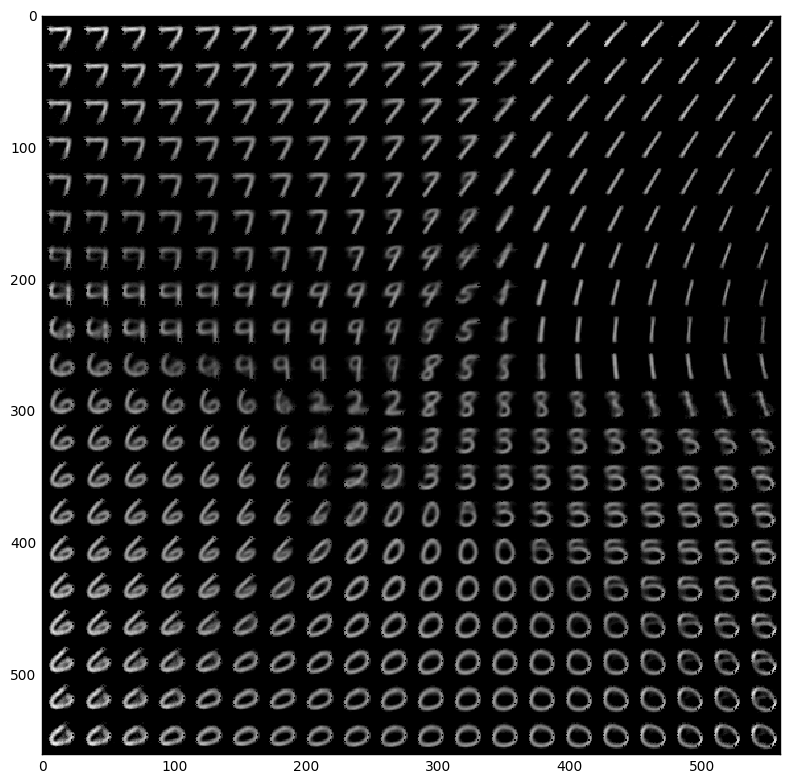

In [108]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mean = np.array([[xi, yi]])
        x_mean = vae.generate(sess, z_mean=z_mean)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper",
           interpolation="nearest",
           cmap="gray")
plt.tight_layout()
plt.show()

## GIF Animation of Latent Space During Training

In [ ]:
import os
from io import BytesIO
import PIL.Image
import scipy.misc
import scipy.io
from IPython.display import clear_output, Image, display

In [56]:
# define model params
layers_encoder = [784, 400, 400]
layer_latent = 2
layers_decoder = [400, 400, 784]

# initialize model
vae = VAE(layers_encoder=layers_encoder, 
          layer_latent=layer_latent,
          layers_decoder=layers_decoder)

In [57]:
# training details
batch_size = 100
display_iters = None
iters_per_image = np.logspace(0, 3, num=50).astype(int)

# image details
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

# store processed images
dir_path = '/home/mattw/Desktop/test_movie'  
saving = 1

for epoch, iters in enumerate(iters_per_image):
    
    # output updates
    print('\rEpoch %03g of %03g - training for %05g iters' % 
          (epoch+1, iters_per_image.size, iters), end='')
    
    # train model
    vae.train_iters(sess, batch_size=batch_size,
                          training_iters=iters,
                          display_iters=display_iters)
    
    # create latent state representation
    canvas = np.empty((28*ny, 28*nx))
    for i, yi in enumerate(x_values):
        for j, xi in enumerate(y_values):
            z_mean = np.array([[xi, yi]])
            x_mean = vae.generate(sess, z_mean=z_mean)
            canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)
    
    # save output
    if saving:
        file_name = 'vae-mnist_epoch_%03i.jpg' % epoch
        file_path = '/'.join([dir_path, file_name])
        canvas = np.uint8(255*canvas)
        PIL.Image.fromarray(canvas).save(file_path, 'jpeg')


Epoch 049 of 050 - training for 01000 iters

### to create a gif:
convert -delay 4x120 -loop 0 *.jpg animated.gif

take all jpgs in current directory and turn them into a gif that loops indefinitely, with a framerate of 120/4 = 30 fps

In [5]:
%reload_ext watermark
%watermark -a "Matt Whiteway" -d -v -m -p numpy,tensorflow

Matt Whiteway 2017-03-14 

CPython 2.7.12
IPython 4.2.0

numpy 1.12.0
tensorflow 0.10.0

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.4.0-66-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
